# FEATURES ANALYSIS

In [3]:
import contextlib
import gc
import joblib
import pickle
import numpy as np
import pandas as pd

from report.tsne import tsne_scatter
# from report.umap import umap_scatter
from models.processors import pca_and_normalization

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

@contextlib.contextmanager
def clear_memory():
    try:
        yield
    finally:
        gc.collect()

In [2]:
DVGG_PATH = "./experiments/dvgg/version_0/artifacts/2"

clu = joblib.load(f'{DVGG_PATH}/clustering.dump')

with open(f'{DVGG_PATH}/features.dump', 'rb') as f:
    features = np.load(f)

with open(f'{DVGG_PATH}/features-targets.dump', 'rb') as f:
    feature_targets = np.load(f)

with open(f"./experiments/dvgg/version_0/dvgg-original-targets.dump", "rb") as f:
    original_train_targets = pickle.load(f)

data = pca_and_normalization(features, apply_normalization=False, apply_l2_normalization=False, pca=2)
data = pd.DataFrame(data)
data['targets'] = original_train_targets

## ORIGINAL GROUPS

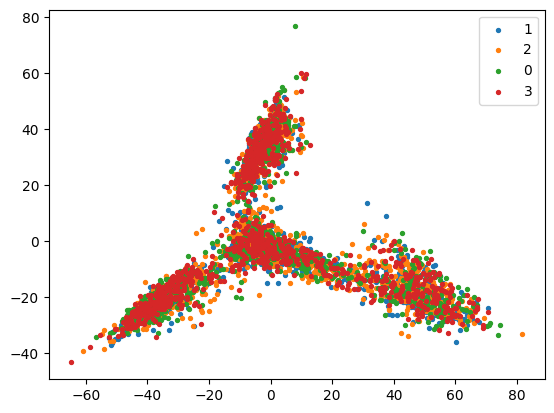

In [22]:
for i in data['targets'].unique():
    plt.scatter(data[data['targets'] == i][0], data[data['targets'] == i][1], marker='o', s=8, label=i)
plt.legend()
plt.show()

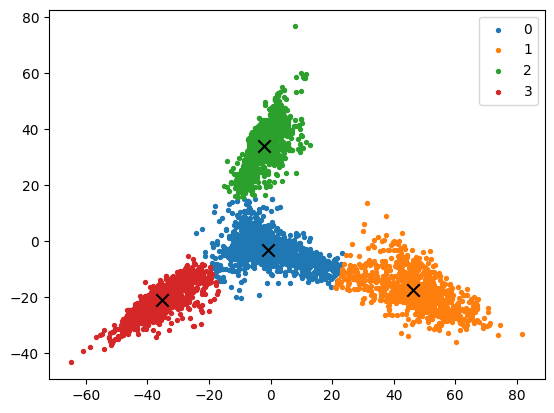

In [23]:
clu = KMeans(init="k-means++", n_clusters=4, n_init=20, random_state=333, verbose=0)
clu.fit(data[[0, 1]])
centroids = clu.cluster_centers_
labels = clu.labels_
u_labels = np.unique(labels)
 
for i in u_labels:
    plt.scatter(data[labels == i][0], data[labels == i][1], marker='o', s=8, label=i)

plt.scatter(centroids[:, 0] , centroids[:, 1] , s=80, marker='x', color='k')

plt.legend()
plt.show()

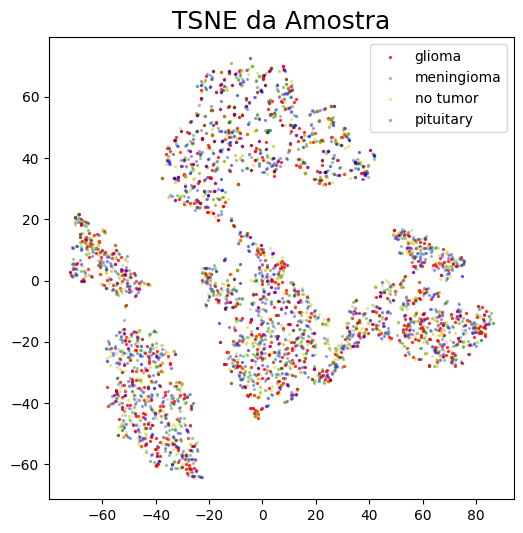

In [28]:
tsne_scatter(features, labels=original_train_targets, dimensions=2)

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


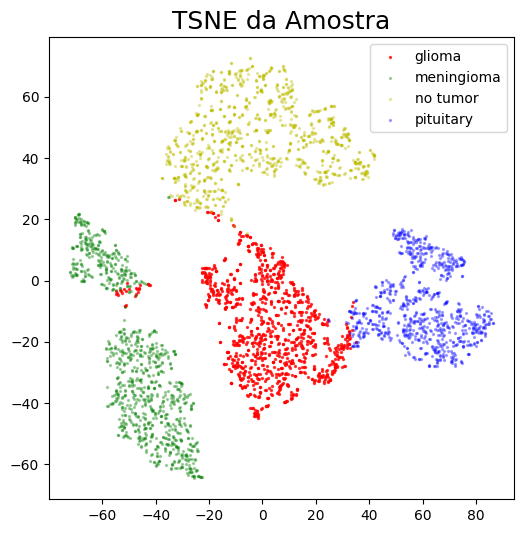

In [10]:
tsne_scatter(features, labels=feature_targets, dimensions=2)

In [ ]:
with clear_memory():
    umap_scatter(features, labels=clu.labels_, dimensions=2)

# LAYER WISE PROPAGATION RELEVANCE

In [80]:
import os
import torch
import copy
import pandas as pd
import shap
import numpy as np
import random
import pickle
from PIL import Image
from models.vgg import VGG
from models.vgg_deep import DVGG
from data.brain_tumor_mri import BrainTumorMRI
from torchvision import transforms
from torchvision.transforms import functional as F
from interpret.layer_wise_rp import LayerWiseRP
from report.lwrp import plot_relevance, analyze_example
from models.timer import Timer
from torch.utils.data import DataLoader

In [21]:
CUDA_AVAILABLE = torch.cuda.is_available()
DEVICE = torch.device("cpu:0")
DATASETS_PATH = './datasets/'

brain_tumor = BrainTumorMRI(DATASETS_PATH, train_size=0.8, val_size=0.2, random_state=333, transformations=transforms.Compose(
            [
                transforms.Resize((255, 255)),
                transforms.ToTensor(),
            ]
        ))

## LOADING MODELS

In [3]:
VGG_PATH = "./experiments/vgg/version_0/checkpoints/vgg-epoch=29-train_loss=0.3726-train_acc=0.8694-val_loss=0.3531-val_acc=0.8716.ckpt"
VGG_PATH = "./experiments/vgg/version_0/checkpoints/vgg-epoch=14-train_loss=0.0234-train_acc=0.9920-val_loss=0.0958-val_acc=0.9737.ckpt"
vgg = VGG.load_from_checkpoint(VGG_PATH)

In [4]:
DVGG_PATH = "./experiments/dvgg/version_0/checkpoints/dvgg-epoch=2-train_loss=0.1296-train_acc=0.9587-val_loss=0.0915-val_acc=0.9667.ckpt"
DVGG_PATH = "./experiments/dvgg/version_0/checkpoints/dvgg-epoch=27-train_loss=0.0349-train_acc=0.9867-val_loss=0.0819-val_acc=0.9860.ckpt"
dvgg = DVGG.load_from_checkpoint(DVGG_PATH)

## ANALYZING IMAGES

In [22]:
dataset = brain_tumor.test_dataset
dataloader = brain_tumor.test_dataloader

In [23]:
dataset.class_to_idx

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [24]:
samples = pd.DataFrame(dataset.imgs, columns=["img", "target"]).groupby("target").sample(1, random_state=3).reset_index()
samples

index                                                img  target
0     84  datasets/brain-tumor-mri-dataset/Testing/gliom...       0
1    515  datasets/brain-tumor-mri-dataset/Testing/menin...       1
2    974  datasets/brain-tumor-mri-dataset/Testing/notum...       2
3   1159  datasets/brain-tumor-mri-dataset/Testing/pitui...       3

In [25]:
data = []
targets = []
for d, t in dataloader:
    data.append(d)
    targets.append(t)
data = np.concatenate(data)
targets = np.concatenate(targets)

In [13]:
def analyze_image(model, image_id, data, labels):
    lw = LayerWiseRP()
    original_image = torch.from_numpy(data[image_id])
    original_label = labels[image_id]
    
    image_lwrp = lw.apply(model, original_image, DEVICE)
    original_image = original_image.unsqueeze(0)
    prediction = model(original_image).max(1).indices.detach().cpu().numpy()
    original_image = original_image.squeeze(0)
    
    analyze_example(
        image=F.to_pil_image(original_image),
        label=original_label.item(),
        image_lwrp=image_lwrp[:, :, 0],
        pred_label=prediction[0]
    )

Ground Truth for this image:  0
Prediction was:  1
This image is not classified correctly.


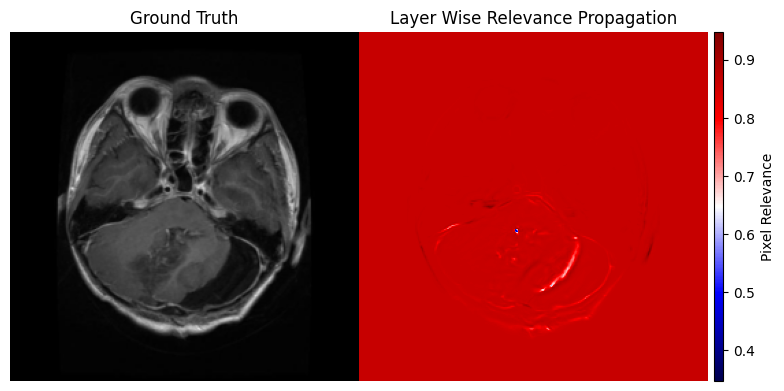

Ground Truth for this image:  0
Prediction was:  0


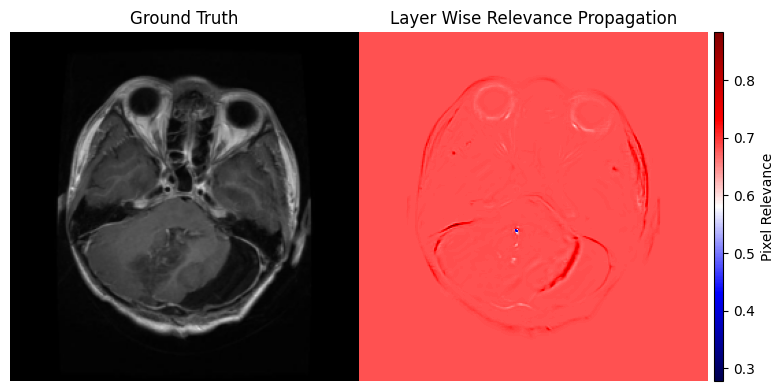

Ground Truth for this image:  1
Prediction was:  1


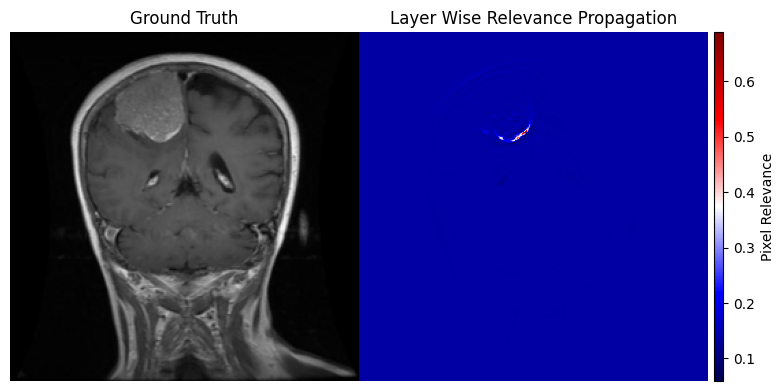

Ground Truth for this image:  1
Prediction was:  1


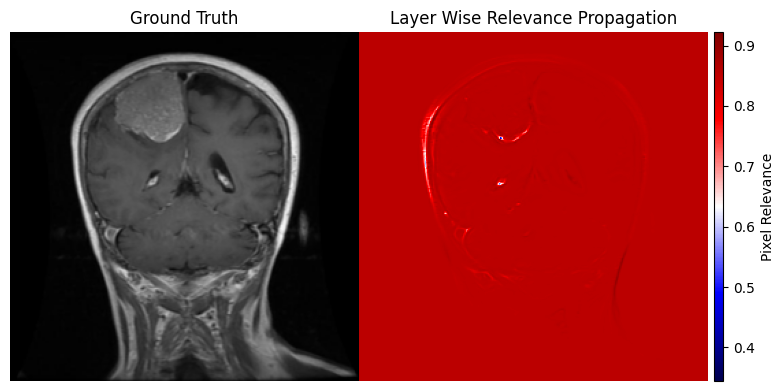

Ground Truth for this image:  2
Prediction was:  2


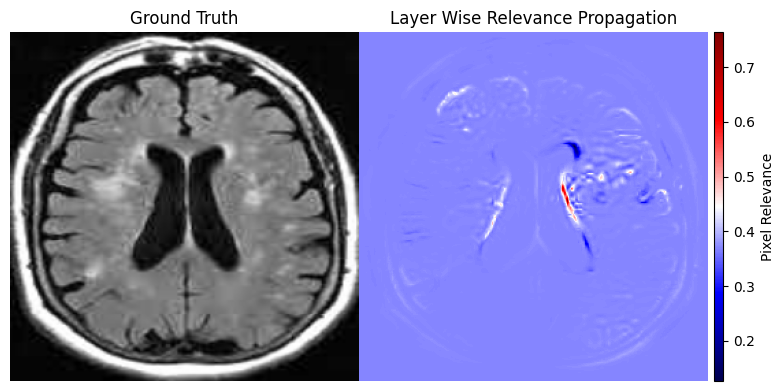

Ground Truth for this image:  2
Prediction was:  2


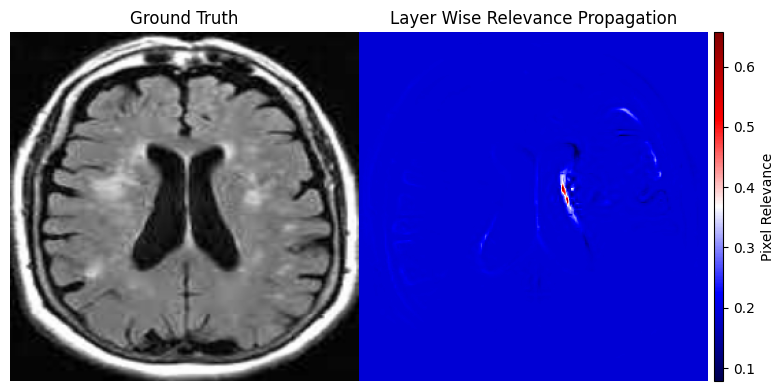

Ground Truth for this image:  3
Prediction was:  1
This image is not classified correctly.


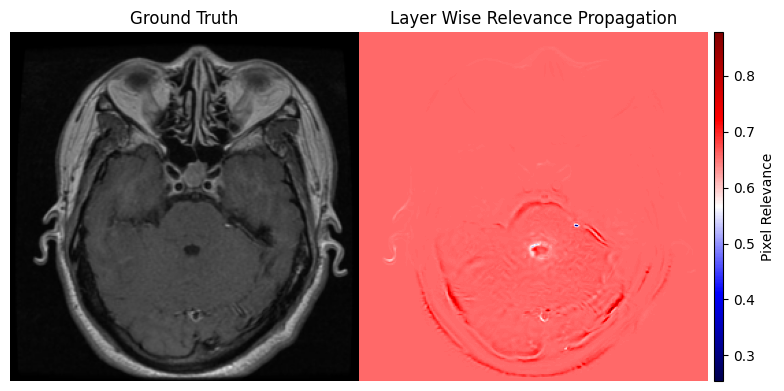

Ground Truth for this image:  3
Prediction was:  2
This image is not classified correctly.


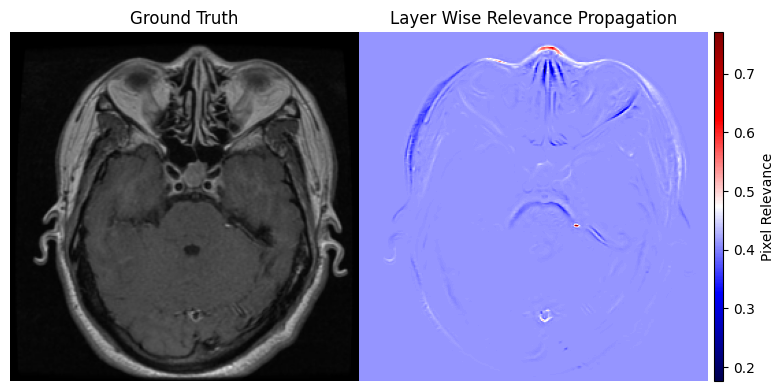

In [26]:
for row in samples.iterrows():
    index = row[1]["index"]
    analyze_image(model=vgg, image_id=index, data=data, labels=targets)
    analyze_image(model=dvgg, image_id=index, data=data, labels=targets)

# SHAP

In [27]:
# Load 100 images from training for background
shap_loader = DataLoader(brain_tumor.train_dataset, batch_size=100, shuffle=True)
background, _ = next(iter(shap_loader))
background = background.to(DEVICE)

In [42]:
# Create SHAP explainer 
vgg_explainer = shap.DeepExplainer(vgg, background)
dvgg_explainer = shap.DeepExplainer(dvgg, background)

In [32]:
transformations = brain_tumor.train_dataset.transform

test_samples = samples["img"].apply(Image.open).apply(lambda x: x.convert('RGB')).tolist()
# test_samples = np.array(test_samples)

In [141]:
test_input = [transformations(img) for img in test_samples]
test_input = torch.stack(test_input).to(DEVICE)

In [43]:
shap_values_vgg = []
shap_values_dvgg = []
for s in test_samples:
    i = transformations(s).unsqueeze(0)
    with Timer(name="shap-vgg") as t:
        shap_values = vgg_explainer.shap_values(i)
        shap_values_vgg.append(shap_values)
    with Timer(name="shap-dvgg") as t:
        shap_values = dvgg_explainer.shap_values(i)
        shap_values_dvgg.append(shap_values)

Elapsed time: 383.6636 seconds
Elapsed time: 399.0293 seconds
Elapsed time: 401.3178 seconds
Elapsed time: 402.5948 seconds


In [82]:
with open("experiments/shap_values_vgg.dump", "wb") as f:
    pickle.dump(shap_values_vgg, f)
with open("experiments/shap_values_dvgg.dump", "wb") as f:
    pickle.dump(shap_values_dvgg, f)

In [83]:
with open("experiments/shap_values_vgg.dump", "rb") as f:
    shap_values_vgg = pickle.load(f)
with open("experiments/shap_values_dvgg.dump", "rb") as f:
    shap_values_dvgg = pickle.load(f)

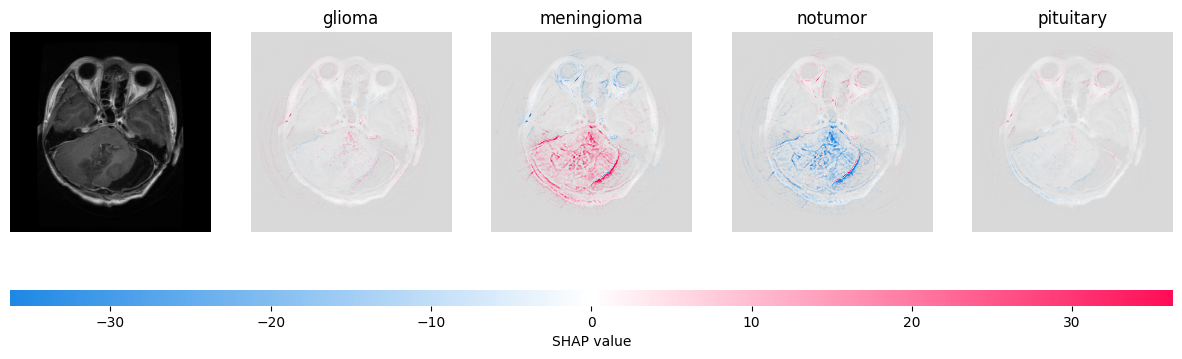

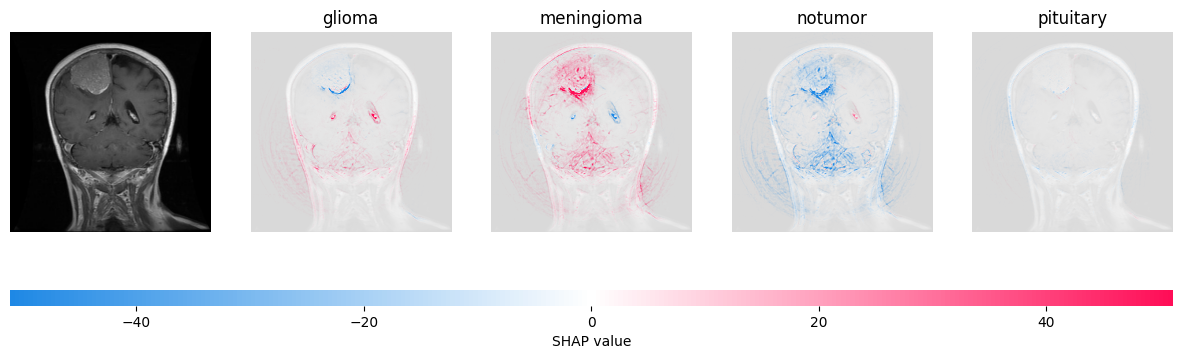

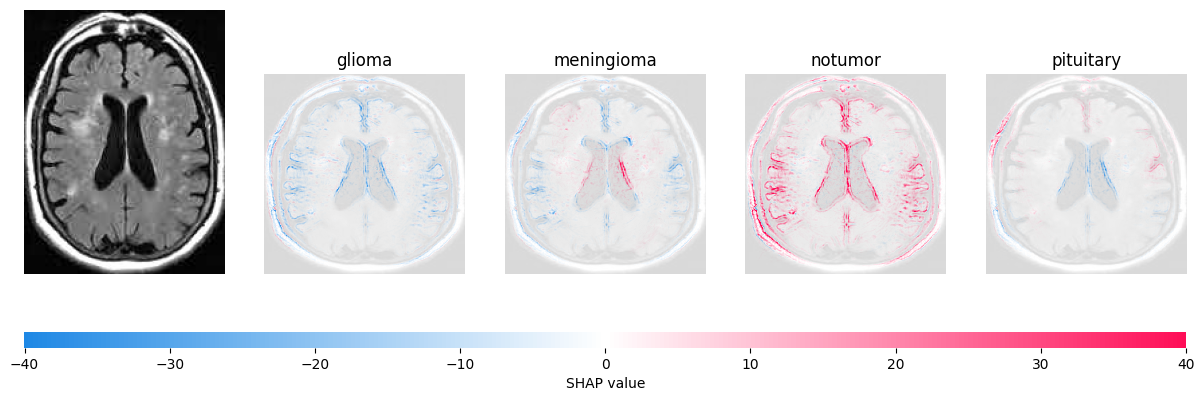

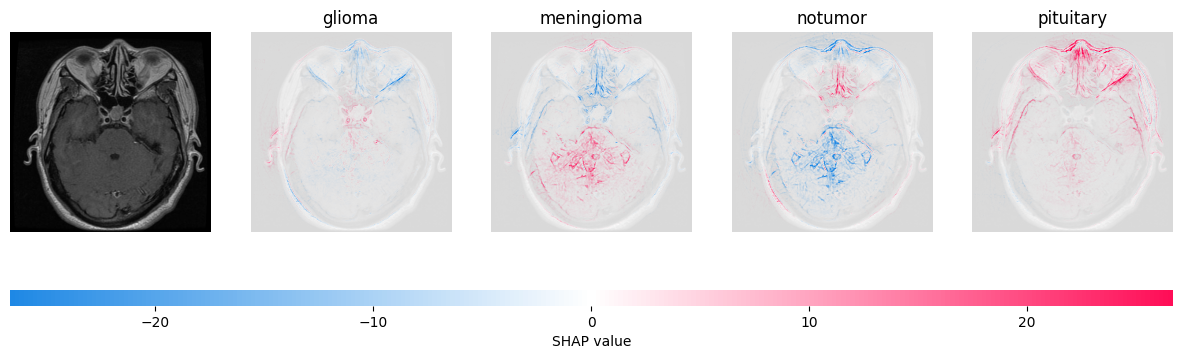

In [41]:
# Reshape shap values and images for plotting
for sh, i in zip(shap_values_vgg, test_samples):
    shap_numpy = list(np.array(sh).transpose(0, 1, 3, 4, 2))
    shap.image_plot(shap_values=shap_numpy, pixel_values=np.array([i]), labels=['glioma', 'meningioma', 'notumor', 'pituitary'], show=True)

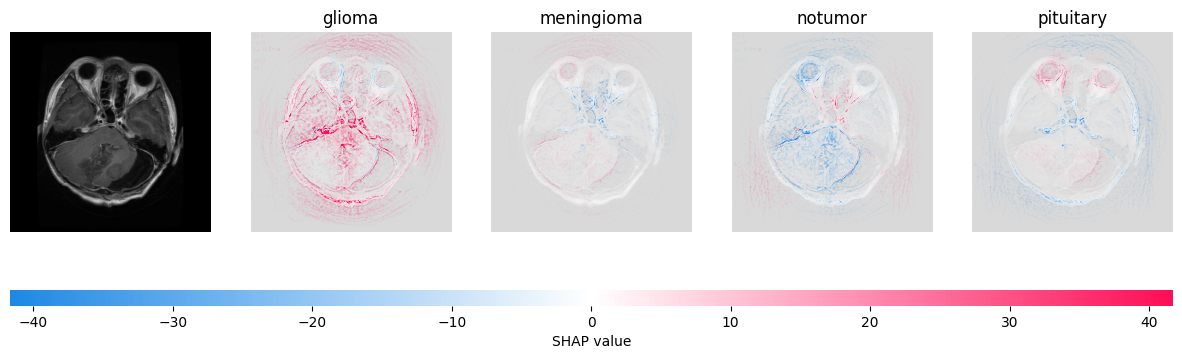

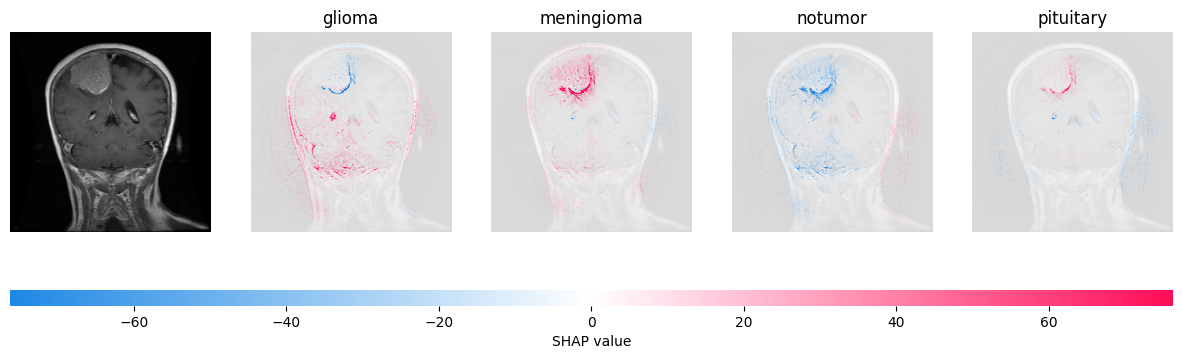

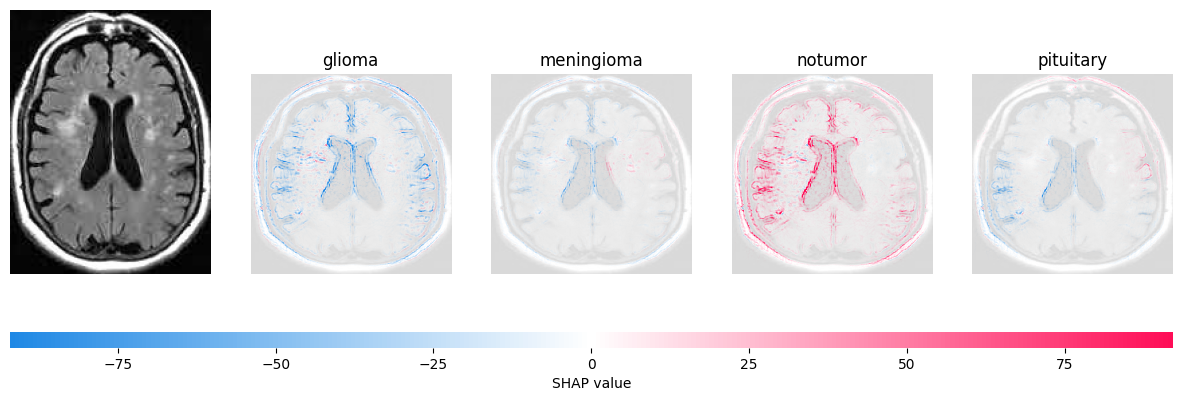

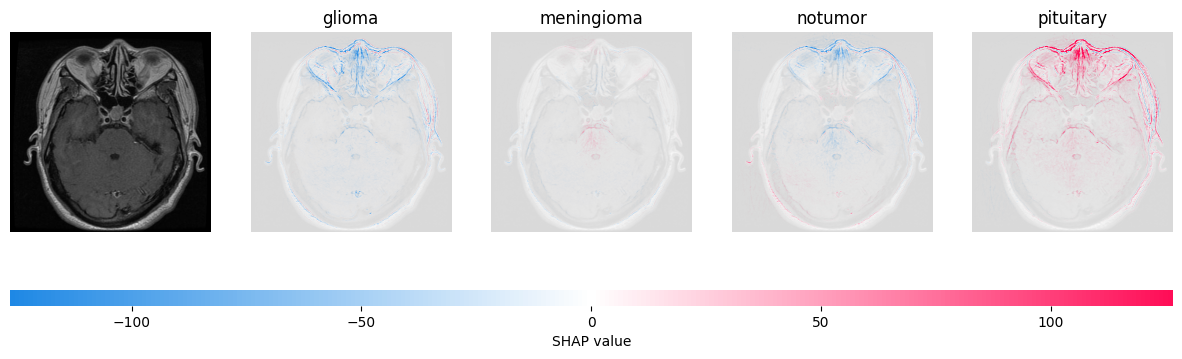

In [44]:
# Reshape shap values and images for plotting
for sh, i in zip(shap_values_dvgg, test_samples):
    shap_numpy = list(np.array(sh).transpose(0, 1, 3, 4, 2))
    shap.image_plot(shap_values=shap_numpy, pixel_values=np.array([i]), labels=['glioma', 'meningioma', 'notumor', 'pituitary'], show=True)

In [277]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from typing import Optional
from shap.plots import colors
from shap._explanation import Explanation
from shap.utils._legacy import kmeans
from matplotlib.colors import Colormap


def shap_plot(
    shap_values: Explanation or np.ndarray,
    pixel_values: Optional[np.ndarray] = None,
    labels: Optional[list or np.ndarray] = None,
    true_labels: Optional[list] = None,
    labelpad: Optional[float] = None,
    cmap: Optional[str or Colormap] = colors.red_transparent_blue,
    show: Optional[bool] = True,
    plot_shape=(3, 2),
    figsize=(9, 9),
    save_as: Optional[str] = None,
):
    """Plots SHAP values for image inputs.

    Copied and modified from:
    https://github.com/shap/shap/blob/master/shap/plots/_image.py

    Parameters
    ----------
    shap_values : [numpy.array]
        List of arrays of SHAP values. Each array has the shape
        (# samples x width x height x channels), and the
        length of the list is equal to the number of model outputs that are being
        explained.

    pixel_values : numpy.array
        Matrix of pixel values (# samples x width x height x channels) for each image.
        It should be the same
        shape as each array in the ``shap_values`` list of arrays.

    labels : list or np.ndarray
        List or ``np.ndarray`` (# samples x top_k classes) of names for each of the
        model outputs that are being explained.

    true_labels: list
        List of a true image labels to plot.

    width : float
        The width of the produced matplotlib plot.

    labelpad : float
        How much padding to use around the model output labels.

    show : bool
        Whether ``matplotlib.pyplot.show()`` is called before returning.
        Setting this to ``False`` allows the plot
        to be customized further after it has been created.

    Examples
    --------

    See `image plot examples <https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/image.html>`_.

    """
    # support passing an explanation object
    if str(type(shap_values)).endswith("Explanation'>"):
        shap_exp = shap_values
        # feature_names = [shap_exp.feature_names]
        # ind = 0
        if len(shap_exp.output_dims) == 1:
            shap_values = [
                shap_exp.values[..., i] for i in range(shap_exp.values.shape[-1])
            ]
        elif len(shap_exp.output_dims) == 0:
            shap_values = shap_exp.values
        else:
            raise Exception(
                "Number of outputs needs to have support added!! (probably a simple fix)"
            )
        if pixel_values is None:
            pixel_values = shap_exp.data
        if labels is None:
            labels = shap_exp.output_names

    # multi_output = True
    if not isinstance(shap_values, list):
        # multi_output = False
        shap_values = [shap_values]

    if len(shap_values[0].shape) == 3:
        shap_values = [v.reshape(1, *v.shape) for v in shap_values]
        pixel_values = pixel_values.reshape(1, *pixel_values.shape)

    # labels: (rows (images) x columns (top_k classes) )
    if labels is not None:
        if isinstance(labels, list):
            labels = np.array(labels).reshape(1, -1)

    # if labels is not None:
    #     labels = np.array(labels)
    #     if labels.shape[0] != shap_values[0].shape[0] and labels.shape[0] == len(shap_values):
    #         labels = np.tile(np.array([labels]), shap_values[0].shape[0])
    #     assert labels.shape[0] == shap_values[0].shape[0], "Labels must have same row count as shap_values arrays!"
    #     if multi_output:
    #         assert labels.shape[1] == len(shap_values), "Labels must have a column for each output in shap_values!"
    #     else:
    #         assert len(labels[0].shape) == 1, "Labels must be a vector for single output shap_values."

    label_kwargs = {} if labelpad is None else {"pad": labelpad}

    # plot our explanations
    x = pixel_values
    # fig_size = np.array([3 * (len(shap_values) + 1), 2.5 * (x.shape[0] + 1)])
    # if fig_size[0] > width:
    #     fig_size *= width / fig_size[0]

    if plot_shape is None:
        nrows, ncols = x.shape[0], len(shap_values) + 1
    else:
        nrows, ncols = plot_shape

    fig = plt.figure(figsize=figsize)  # Notice the equal aspect ratio
    axes = [fig.add_subplot(nrows, ncols, i + 1) for i in range(nrows * ncols)]

    for row in range(x.shape[0]):
        x_curr = x[row].copy()

        # make sure we have a 2D array for grayscale
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
            x_curr = x_curr.reshape(x_curr.shape[:2])

        # if x_curr.max() > 1:
        #     x_curr /= 255.

        # get a grayscale version of the image
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
            x_curr_gray = (
                0.2989 * x_curr[:, :, 0]
                + 0.5870 * x_curr[:, :, 1]
                + 0.1140 * x_curr[:, :, 2]
            )  # rgb to gray
            x_curr_disp = x_curr
        elif len(x_curr.shape) == 3:
            x_curr_gray = x_curr.mean(2)

            # for non-RGB multi-channel data we show an RGB image where each of the three channels is a scaled k-mean center
            flat_vals = x_curr.reshape(
                [x_curr.shape[0] * x_curr.shape[1], x_curr.shape[2]]
            ).T
            flat_vals = (flat_vals.T - flat_vals.mean(1)).T
            means = kmeans(flat_vals, 3, round_values=False).data.T.reshape(
                [x_curr.shape[0], x_curr.shape[1], 3]
            )
            x_curr_disp = (means - np.percentile(means, 0.5, (0, 1))) / (
                np.percentile(means, 99.5, (0, 1)) - np.percentile(means, 1, (0, 1))
            )
            x_curr_disp[x_curr_disp > 1] = 1
            x_curr_disp[x_curr_disp < 0] = 0
        else:
            x_curr_gray = x_curr
            x_curr_disp = x_curr

        axes[0].imshow(x_curr_disp, cmap=plt.get_cmap("gray"))
        if true_labels:
            axes[0].set_title(true_labels[row], **label_kwargs)
        axes[0].axis("off")

        if len(shap_values[0][row].shape) == 2:
            abs_vals = np.stack(
                [np.abs(shap_values[i]) for i in range(len(shap_values))], 0
            ).flatten()
        else:
            abs_vals = np.stack(
                [np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0
            ).flatten()
        max_val = np.nanpercentile(abs_vals, 99.9)

        for i in range(len(shap_values)):
            if labels is not None:
                axes[i + 1].set_title(labels[row, i], **label_kwargs)

            sv = (
                shap_values[i][row]
                if len(shap_values[i][row].shape) == 2
                else shap_values[i][row].sum(-1)
            )
            axes[i + 1].imshow(
                x_curr_gray,
                cmap=plt.get_cmap("gray"),
                alpha=0.15,
                extent=(-1, sv.shape[1], sv.shape[0], -1),
            )
            im = axes[i + 1].imshow(sv, cmap=cmap, vmin=-max_val, vmax=max_val)
            axes[i + 1].axis("off")

    fig.delaxes(axes[5])

    fig.subplots_adjust(wspace=0.05, hspace=0.02)

    cb = plt.colorbar(
        im,
        ax=axes,
        orientation="horizontal",
        label="SHAP value",
        pad=0.01,
    )
    cb.outline.set_visible(False)

    if save_as is not None:
        plt.savefig(save_as, dpi=300)
    if show:
        plt.show()
    plt.close(fig)


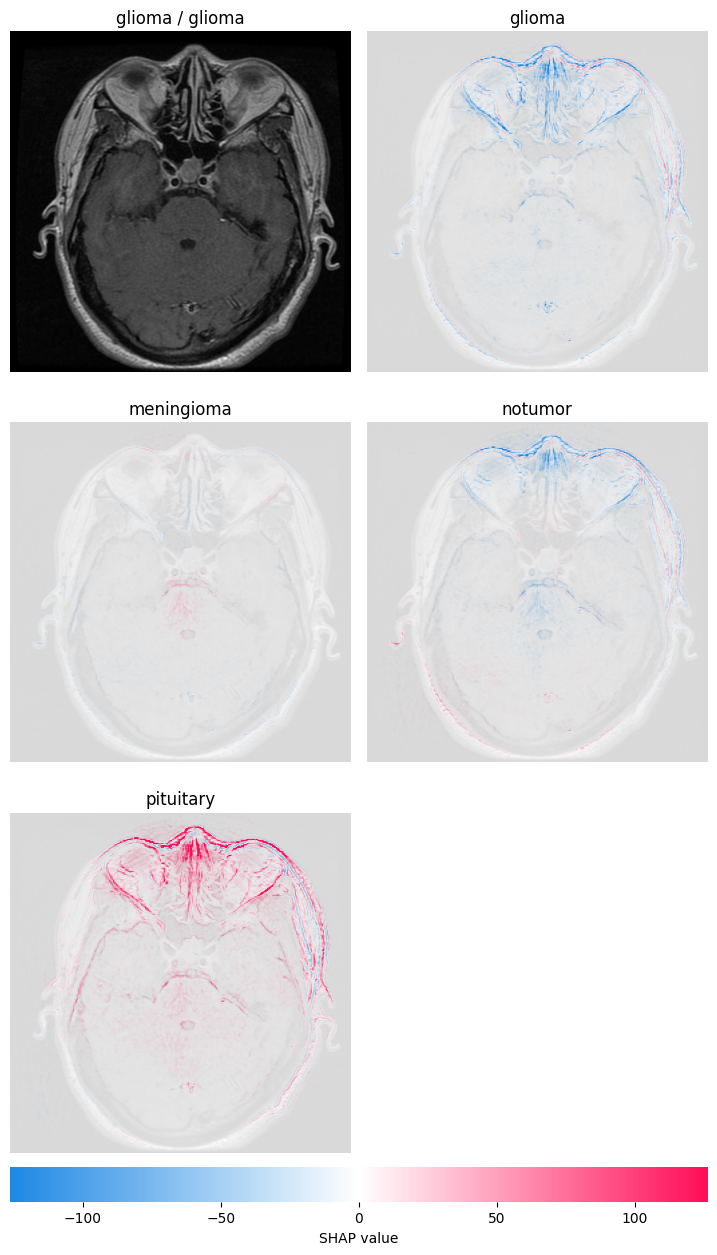

In [278]:
shap_plot(shap_values=shap_numpy, pixel_values=np.array([i]), labels=['glioma', 'meningioma', 'notumor', 'pituitary'], true_labels=['glioma / glioma'], figsize=(9, 18), save_as='graphic.png')

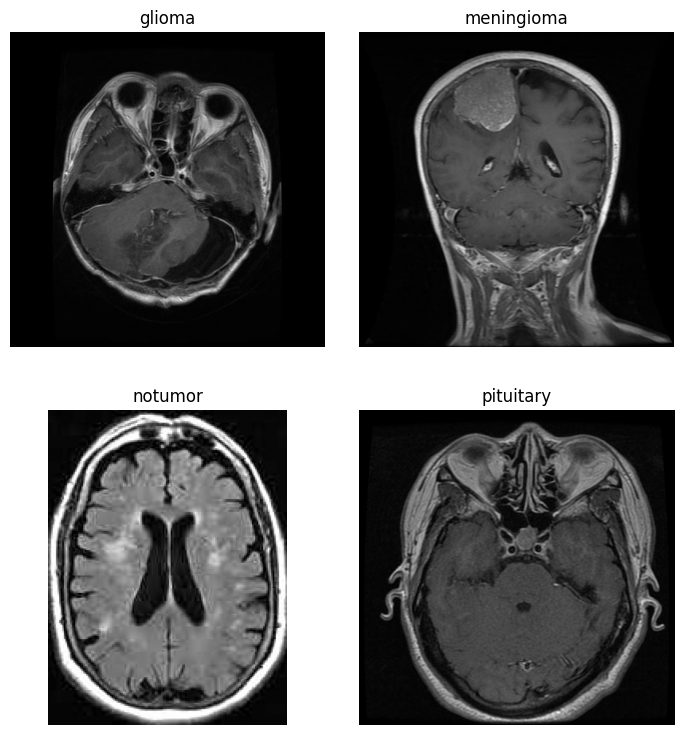

In [224]:
def plot_examples(images_arr, labels, plot_shape=(2,2), hspace=0.2, vspace=0.2, show=True, save_as=None):
    nrows, ncols = plot_shape
    fig, axes = plt.subplots(nrows, ncols, figsize=(9, 9))
    axes = axes.flatten()
    for n, (img, ax) in enumerate(zip(images_arr, axes)):
        ax.imshow(img)
        ax.set_title(labels[n])
        ax.axis('off')
        ax.set_aspect('equal')
    plt.subplots_adjust(wspace=0, hspace=0.2)
    if save_as is not None:
        plt.savefig(save_as, dpi=300)
    if show:
        plt.show()
    plt.close(fig)

plot_examples(test_samples, labels=['glioma', 'meningioma', 'notumor', 'pituitary'])